In [1]:
from constants import *
from src.utils import read_config
from src.model.data_preprocessing import DataPreprocessing
from src.model.main_model import FraudDetection
from src.model.data_visualize import visualize_categorical, visualize_continuous, visualize_tsn_pca, visualize_roc_score
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
sns.set(rc={'figure.figsize':(20,10)})


## 1. Read config

In [2]:
cfg = read_config(file_path=PATH_CFG)

## 2. EDA

In [3]:
query_obj = DataPreprocessing(db=DATABASE_URI,
                              cfg=cfg)

### 2.1. `USERS` table

In [4]:
users, transactions = query_obj.convert_main()

[{data_preprocessing.py:88} INFO - USERS. Convert data
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM users
[{etl_query.py:46} INFO - USERS. Shape = (10300, 11)
[{data_preprocessing.py:70} INFO - USERS. Convert date to numeric (days)
[{data_preprocessing.py:76} INFO - USERS. Rename STATE to state_user
[{data_preprocessing.py:91} INFO - TRANSACTIONS. Convert data
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM transactions
[{etl_query.py:46} INFO - TRANSACTIONS. Shape = (688651, 11)
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM fx_rates
[{etl_query.py:46} INFO - FX_RATES. Shape = (838068, 4)
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM currency_details
[{etl_query.py:46}

I've already converted our data frame **users**, but I left origin column for analysis.
What I made:
* **created_date**. Convert from datetime to day (create **created_date_origin**)
* **terms_verasion**. Fill NA `2000-01-01`
* **state**. Drop this column because It's is_fraudster. It'll overfitting our model.
* **first_amount**. Amount of first success transaction (=COMPLETED).
* **first_date**. Date of first transaction
* **diff_date**. Diff of created date of users and the first transaction
* **{}_freq**. Column of the most frequent value in {} column

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10300 entries, 0 to 10299
Data columns (total 27 columns):
id                         10300 non-null object
has_email                  10300 non-null int64
phone_country              10300 non-null object
is_fraudster               10300 non-null bool
terms_version              10300 non-null object
created_date               10300 non-null int64
country                    10300 non-null object
birth_year                 10300 non-null int64
kyc                        10300 non-null object
failed_sign_in_attempts    10300 non-null int64
created_date_origin        10300 non-null datetime64[ns]
terms_version_origin       10300 non-null object
is_lock                    10300 non-null int64
first_amount               10300 non-null float64
first_date                 10300 non-null object
country_gb                 10300 non-null int64
diff_date                  10300 non-null float64
first_success              10300 non-null int64
source_f

In [6]:
users.head()

,id,has_email,phone_country,is_fraudster,terms_version,created_date,country,birth_year,kyc,failed_sign_in_attempts,...,first_success,source_freq,type_freq,state_freq,source_minos,user_id,is_user_country,has_transactions,cnt_currency,mean_amount
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,886,GB,1971,PASSED,0,...,0,GAIA,TOPUP,COMPLETED,0,1872820f-e3ac-4c02-bdc7-727897b60043,0,1,2,33.594229
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,734,GB,1982,PASSED,0,...,0,GAIA,CARD_PAYMENT,COMPLETED,0,545ff94d-66f8-4bea-b398-84425fb2301e,1,1,1,13.559795
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,1184,ES,1973,PASSED,0,...,0,GAIA,CARD_PAYMENT,COMPLETED,0,10376f1a-a28a-4885-8daa-c8ca496026bb,1,1,1,87.032657
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,1186,FR,1986,PASSED,0,...,0,HERA,TOPUP,COMPLETED,0,fd308db7-0753-4377-879f-6ecf2af14e4f,0,1,1,47.166105
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,890,GB,1989,PASSED,0,...,0,GAIA,CARD_PAYMENT,COMPLETED,0,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,1,2,52.878173


##### Now we'll choose and analyse features from users df

### 2.1.1. USERS. Research KYC

kyc 
 FAILED 
 NONE 
 PASSED 
 PENDING 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 False 
 2.70 
 27.63 
 69.06 
 0.61 
 
 
 True 
 7.33 
 0.33 
 86.67 
 5.67 
 
 
 All 
 2.83 
 26.83 
 69.57 
 0.76 
 
 
 
 
 
 kyc 
 FAILED 
 NONE 
 PASSED 
 PENDING 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 False 
 270 
 2763 
 6906 
 61 
 10000 
 
 
 True 
 22 
 1 
 260 
 17 
 300 
 
 
 All 
 292 
 2764 
 7166 
 78 
 10300

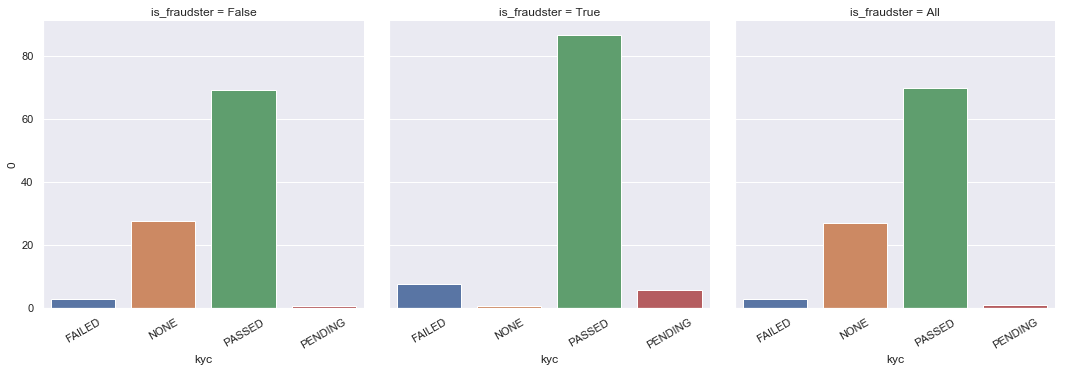

In [7]:
tmp = visualize_categorical(column_y=users.is_fraudster,
                            column_x=users.kyc)

* **Many of non-fraudster users have status `NONE`. I think that we need to check this users. But now we just skip this.**
* **We can see correlation between fraudster user and failed of KYC. So, `FAILED` status can help us to find fraud users**

### 2.1.2.  USERS. Research TERMS_VERSION

terms_version 
 2017-01-16 
 2017-02-02 
 2018-01-01 
 2018-01-13 
 2018-03-20 
 2018-05-25 
 2018-09-20 
 2000-01-01 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 1.40 
 0.67 
 2.26 
 4.37 
 19.76 
 33.52 
 21.60 
 16.42 
 
 
 True 
 0.00 
 3.00 
 4.00 
 2.00 
 38.00 
 30.33 
 0.00 
 22.67 
 
 
 All 
 1.36 
 0.74 
 2.31 
 4.30 
 20.29 
 33.43 
 20.97 
 16.60 
 
 
 
 
 
 terms_version 
 2017-01-16 
 2017-02-02 
 2018-01-01 
 2018-01-13 
 2018-03-20 
 2018-05-25 
 2018-09-20 
 2000-01-01 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 140 
 67 
 226 
 437 
 1976 
 3352 
 2160 
 1642 
 10000 
 
 
 True 
 0 
 9 
 12 
 6 
 114 
 91 
 0 
 68 
 300 
 
 
 All 
 140 
 76 
 238 
 443 
 2090 
 3443 
 2160 
 1710 
 10300

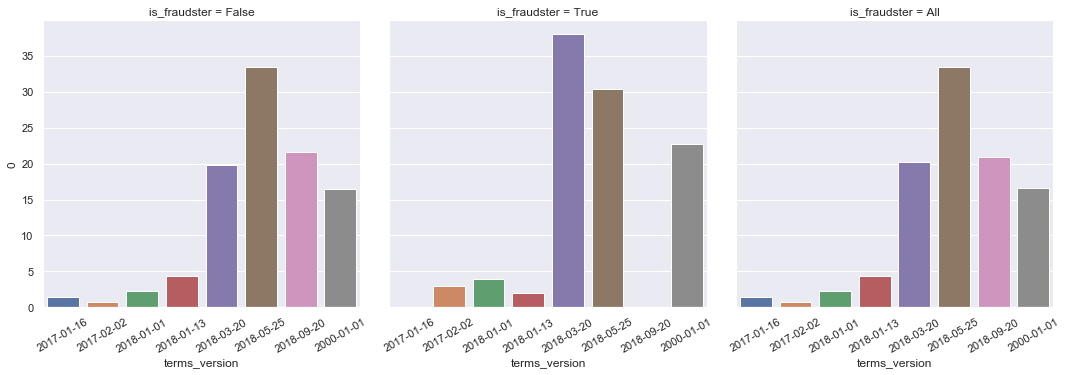

In [8]:
tmp = visualize_categorical(column_y=users.is_fraudster, 
                            column_x=users.terms_version)

* **Fraudiest users have older versions of the system.**
* **Fraudiest users don't have the latest versions of the system. This is due to the fact that, users have long been marked**
* **It's useful feature**

### 2.1.3.  USERS. Research HAS_EMAIL

has_email 
 0 
 1 
 
 
 is_fraudster 
 
 
 
 
 
 
 False 
 6.56 
 93.44 
 
 
 True 
 0.33 
 99.67 
 
 
 All 
 6.38 
 93.62 
 
 
 
 
 
 has_email 
 0 
 1 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 False 
 656 
 9344 
 10000 
 
 
 True 
 1 
 299 
 300 
 
 
 All 
 657 
 9643 
 10300

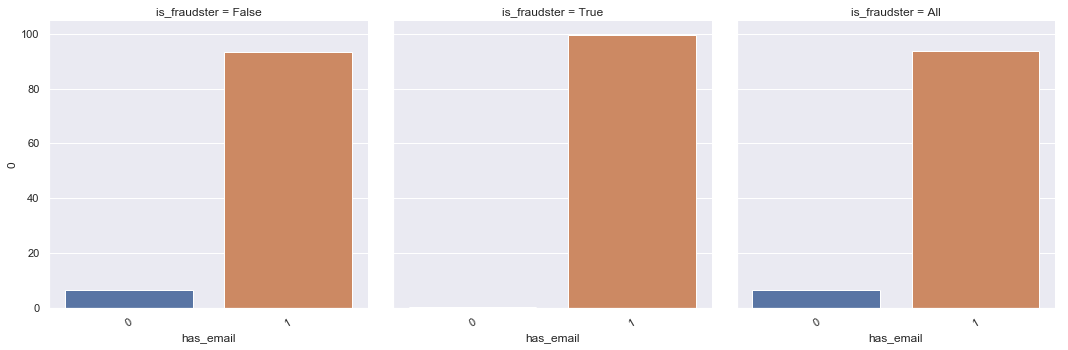

In [9]:
tmp = visualize_categorical(column_y=users.is_fraudster,
                            column_x=users.has_email)

* **Fraudiest users have emails.**
* **It's unuseful feature**

failed_sign_in_attempts 
 0 
 1 
 2 
 3 
 6 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 False 
 99.51 
 0.27 
 0.18 
 0.03 
 0.01 
 
 
 True 
 99.00 
 0.33 
 0.67 
 0.00 
 0.00 
 
 
 All 
 99.50 
 0.27 
 0.19 
 0.03 
 0.01 
 
 
 
 
 
 failed_sign_in_attempts 
 0 
 1 
 2 
 3 
 6 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 False 
 9951 
 27 
 18 
 3 
 1 
 10000 
 
 
 True 
 297 
 1 
 2 
 0 
 0 
 300 
 
 
 All 
 10248 
 28 
 20 
 3 
 1 
 10300

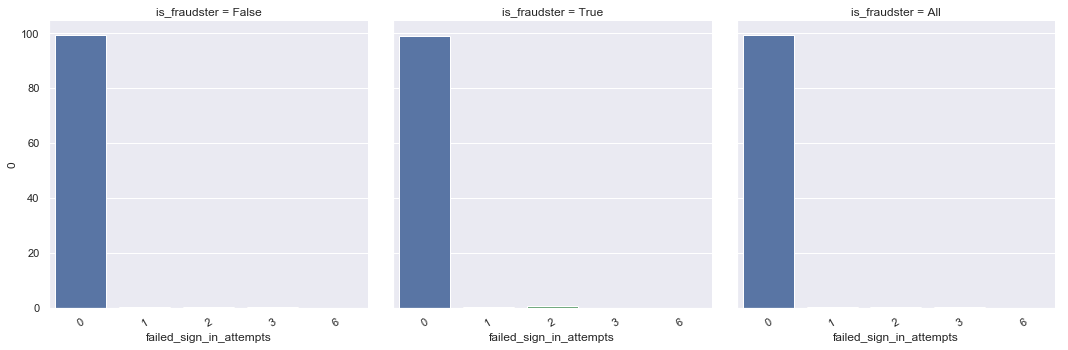

In [10]:
tmp = visualize_categorical(column_y=users.is_fraudster, 
                            column_x=users.failed_sign_in_attempts)

* **It's uninformation feature**

### 2.1.4. USERS. Research CREATED_DATE

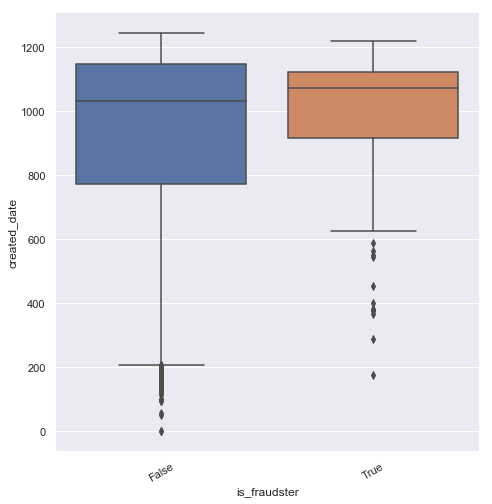

In [11]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='created_date', 
                           df=users, height=7)

* **Fraud users newer. It's useful feature.**

### 2.1.5.  USERS. Research BIRTH_YEAR

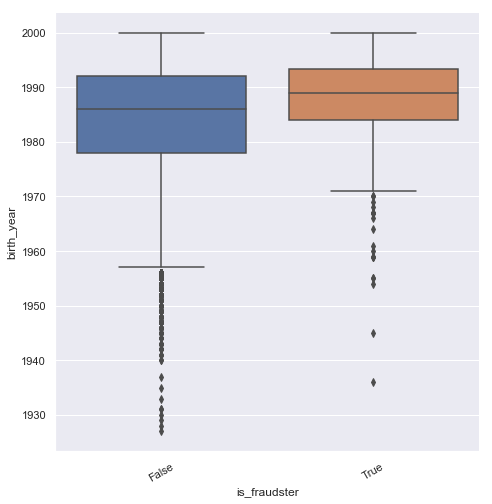

In [12]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='birth_year', 
                           df=users, 
                           height=7)

* **Fraud users younger. It's useful feature.**

### 2.2.15. USERS. Research Country

country 
 BE 
 CZ 
 DE 
 ES 
 FR 
 GB 
 LT 
 NL 
 PL 
 RO 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 1.12 
 1.40 
 2.74 
 4.90 
 16.48 
 54.89 
 5.96 
 1.52 
 8.29 
 2.69 
 
 
 True 
 0.33 
 0.33 
 0.33 
 1.00 
 1.00 
 90.00 
 4.67 
 0.33 
 0.67 
 1.33 
 
 
 All 
 1.09 
 1.36 
 2.66 
 4.76 
 15.92 
 56.16 
 5.91 
 1.48 
 8.02 
 2.64 
 
 
 
 
 
 country 
 BE 
 CZ 
 DE 
 ES 
 FR 
 GB 
 LT 
 NL 
 PL 
 RO 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 90 
 112 
 220 
 393 
 1322 
 4403 
 478 
 122 
 665 
 216 
 8021 
 
 
 True 
 1 
 1 
 1 
 3 
 3 
 270 
 14 
 1 
 2 
 4 
 300 
 
 
 All 
 91 
 113 
 221 
 396 
 1325 
 4673 
 492 
 123 
 667 
 220 
 8321

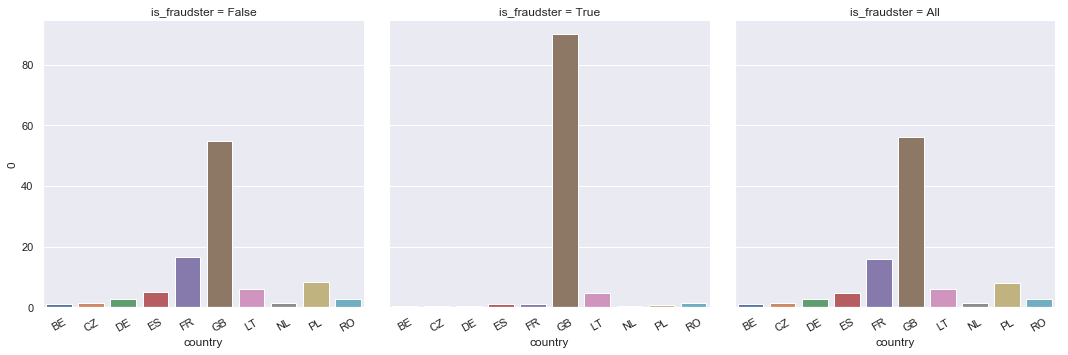

In [13]:
sub_user = users[users.country.isin(users[users.is_fraudster == True].country.unique())]
tmp = visualize_categorical(column_y=sub_user.is_fraudster, 
                            column_x=sub_user.country)

* **Most fraud users from England. But is this feature important?**

## 2.2. `Transactions` table

I've already converted our data frame transactions, but I left origin column for analysis. What I made:

* **amount**. Create table **amount_usd**(convert currency)
* **first_amount**. Amount of first success transaction (=COMPLETED).
* **first_date.** Date of first transaction

In [14]:
transactions.head(2)

,id,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,amount_usd,first_amount,first_date,is_fraudster
0,5a9ee109-e9b3-4598-8dd7-587591e6a470,GBP,3738,COMPLETED,2015-10-11 09:05:43.016,bar,AU,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,50.306980,NaN,NaT,False
1,28d68bf4-460b-4c8e-9b95-bcda9ab596b5,GBP,588,COMPLETED,2015-10-11 20:08:39.150,None,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,7.894569,NaN,NaT,False


In [15]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 15 columns):
id                   688651 non-null object
currency             688651 non-null object
amount               688651 non-null int64
state                688651 non-null object
created_date         688651 non-null datetime64[ns]
merchant_category    223065 non-null object
merchant_country     483073 non-null object
entry_method         688651 non-null object
user_id              688651 non-null object
type                 688651 non-null object
source               688651 non-null object
amount_usd           688651 non-null float64
first_amount         1133 non-null float64
first_date           8021 non-null datetime64[ns]
is_fraudster         688651 non-null bool
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(9)
memory usage: 74.2+ MB


### 2.2.2. TRANSACTIONS. Research Type

type 
 ATM 
 BANK_TRANSFER 
 CARD_PAYMENT 
 P2P 
 TOPUP 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 False 
 6.69 
 2.17 
 63.75 
 8.29 
 19.10 
 
 
 True 
 15.38 
 8.46 
 47.09 
 3.00 
 26.07 
 
 
 All 
 6.87 
 2.30 
 63.39 
 8.18 
 19.25 
 
 
 
 
 
 type 
 ATM 
 BANK_TRANSFER 
 CARD_PAYMENT 
 P2P 
 TOPUP 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 False 
 45088 
 14628 
 429721 
 55902 
 128769 
 674108 
 
 
 True 
 2236 
 1230 
 6849 
 436 
 3792 
 14543 
 
 
 All 
 47324 
 15858 
 436570 
 56338 
 132561 
 688651

(None, <seaborn.axisgrid.FacetGrid at 0x13acfd9b0>)

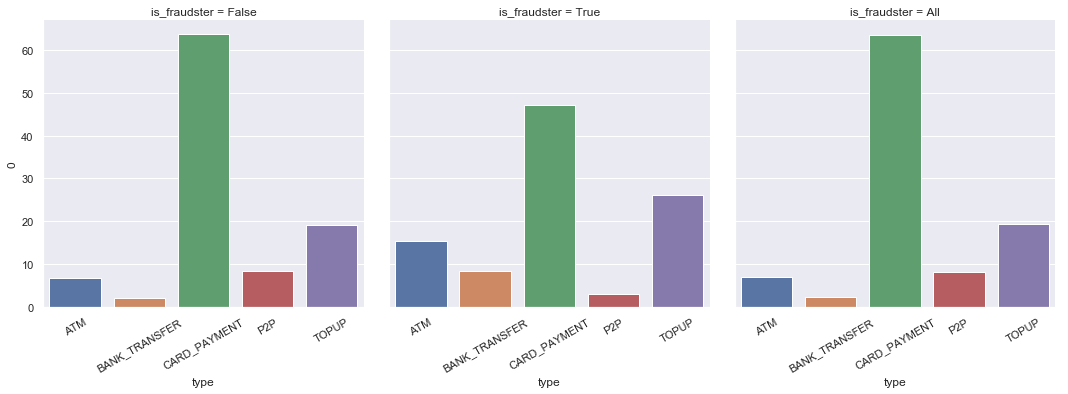

In [16]:
visualize_categorical(column_y=transactions.is_fraudster, column_x=transactions.type)

* **Fraud users more than non-fraud make transactions in ATM/Bank transfer (in %)**
* **It's useful feature**

### 2.2.3. TRANSACTIONS. Research State

state 
 CANCELLED 
 COMPLETED 
 DECLINED 
 FAILED 
 PENDING 
 RECORDED 
 REVERTED 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 False 
 0.07 
 85.15 
 6.45 
 2.39 
 0.37 
 0.01 
 5.56 
 
 
 True 
 0.14 
 72.09 
 15.04 
 4.53 
 0.04 
 0.01 
 8.15 
 
 
 All 
 0.07 
 84.88 
 6.63 
 2.43 
 0.36 
 0.01 
 5.61 
 
 
 
 
 
 state 
 CANCELLED 
 COMPLETED 
 DECLINED 
 FAILED 
 PENDING 
 RECORDED 
 REVERTED 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 495 
 574023 
 43448 
 16104 
 2471 
 89 
 37478 
 674108 
 
 
 True 
 20 
 10484 
 2187 
 659 
 6 
 2 
 1185 
 14543 
 
 
 All 
 515 
 584507 
 45635 
 16763 
 2477 
 91 
 38663 
 688651

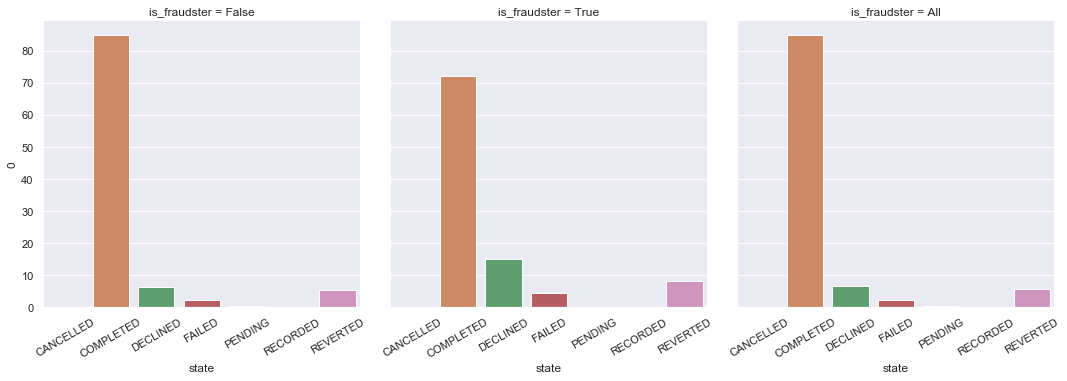

In [17]:
tmp = visualize_categorical(column_y=transactions.is_fraudster, column_x=transactions.state)

* **No information**

### 2.2.4. TRANSACTIONS. Research Source

source 
 APOLLO 
 BRIZO 
 CRONUS 
 GAIA 
 HERA 
 INTERNAL 
 LETO 
 LIMOS 
 MINOS 
 NYX 
 OPHION 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 0.11 
 0.0 
 0.89 
 70.43 
 16.96 
 8.30 
 1.01 
 0.13 
 1.21 
 0.76 
 0.19 
 
 
 True 
 0.12 
 0.0 
 0.80 
 62.47 
 12.02 
 3.00 
 0.97 
 0.36 
 20.02 
 0.22 
 0.02 
 
 
 All 
 0.11 
 0.0 
 0.89 
 70.26 
 16.86 
 8.19 
 1.01 
 0.14 
 1.61 
 0.75 
 0.19 
 
 
 
 
 
 source 
 APOLLO 
 BRIZO 
 CRONUS 
 GAIA 
 HERA 
 INTERNAL 
 LETO 
 LIMOS 
 MINOS 
 NYX 
 OPHION 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 767 
 1 
 6022 
 474746 
 114333 
 55971 
 6794 
 908 
 8145 
 5146 
 1275 
 674108 
 
 
 True 
 17 
 0 
 117 
 9085 
 1748 
 436 
 141 
 53 
 2911 
 32 
 3 
 14543 
 
 
 All 
 784 
 1 
 6139 
 483831 
 116081 
 56407 
 6935 
 961 
 11056 
 5178 
 1278 
 688651

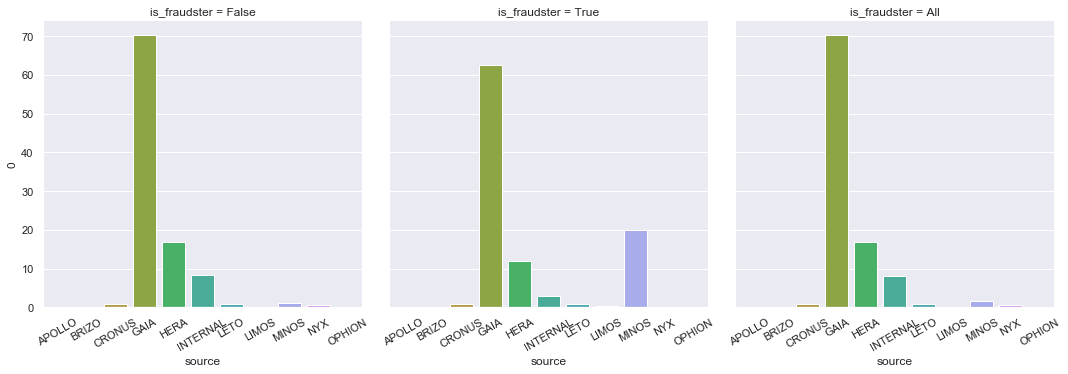

In [18]:
tmp = visualize_categorical(column_y=transactions.is_fraudster, column_x=transactions.source)

* **We can see anomaly in fraud's data (MINOS).**
* **I made a new feature source_minos (bool)**

### 2.2.6. TRANSACTIONS. Research Entry method

entry_method 
 chip 
 cont 
 mags 
 manu 
 mcon 
 misc 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 False 
 26.75 
 23.58 
 3.30 
 13.42 
 0.07 
 32.88 
 
 
 True 
 23.12 
 12.96 
 0.24 
 24.18 
 0.01 
 39.48 
 
 
 All 
 26.67 
 23.36 
 3.24 
 13.64 
 0.07 
 33.02 
 
 
 
 
 
 entry_method 
 chip 
 cont 
 mags 
 manu 
 mcon 
 misc 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 False 
 180299 
 158987 
 22276 
 90435 
 490 
 221621 
 674108 
 
 
 True 
 3363 
 1885 
 35 
 3517 
 2 
 5741 
 14543 
 
 
 All 
 183662 
 160872 
 22311 
 93952 
 492 
 227362 
 688651

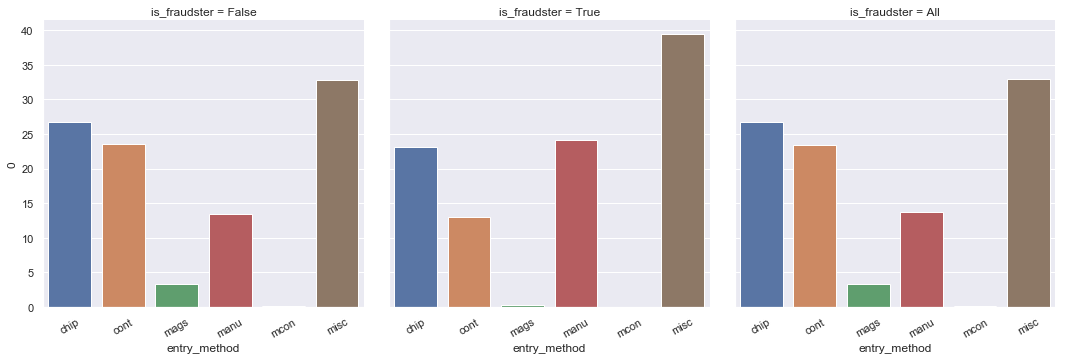

In [19]:
tmp = visualize_categorical(column_y=transactions.is_fraudster, column_x=transactions.entry_method)

**No information feature**

### 2.2.7. TRANSACTIONS. Research Currency

cnt_currency 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 22.78 
 42.86 
 21.87 
 8.65 
 2.58 
 0.84 
 0.31 
 0.05 
 0.06 
 
 
 True 
 0.33 
 83.33 
 13.00 
 2.33 
 1.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 All 
 22.13 
 44.04 
 21.61 
 8.47 
 2.53 
 0.82 
 0.30 
 0.05 
 0.06 
 
 
 
 
 
 cnt_currency 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 False 
 2278 
 4286 
 2187 
 865 
 258 
 84 
 31 
 5 
 6 
 10000 
 
 
 True 
 1 
 250 
 39 
 7 
 3 
 0 
 0 
 0 
 0 
 300 
 
 
 All 
 2279 
 4536 
 2226 
 872 
 261 
 84 
 31 
 5 
 6 
 10300

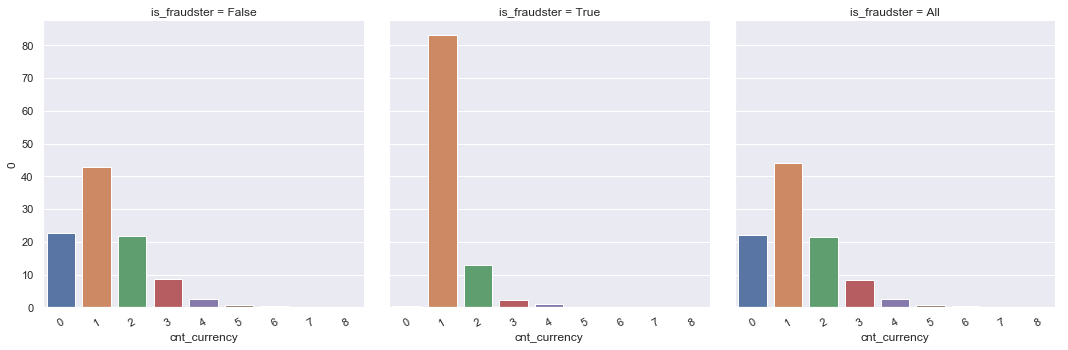

In [20]:
tmp = visualize_categorical(column_y=users.is_fraudster, column_x=users.cnt_currency)

* **The number of currency for different users. We can see that Fraud users usually make transactions in the same currency**
* **It's useful feature**

### 2.2.8. TRANSACTIONS. Research amount  (first_transaction) vs state (small)

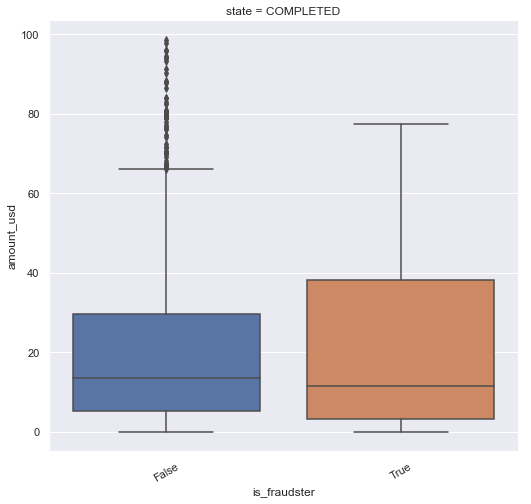

In [21]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='amount_usd', col='state',col_wrap=3,
                           df=transactions[transactions.first_amount < 100], 
                           height=7)

* **No information**

### 2.2.9. TRANSACTIONS. Research amount (first_transaction) vs state (big)

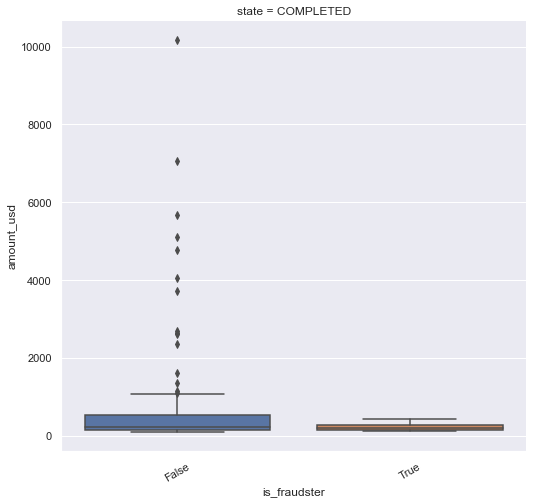

In [22]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='amount_usd', col='state',col_wrap=3,
                           df=transactions[transactions.first_amount > 100], 
                           height=7)

* **Non-Fraud users make first transactions for a larger amount**

### 2.2.10. TRANSACTIONS. Research max amount (small)

In [23]:
max_amount = transactions.groupby(['user_id', 'is_fraudster'])['amount_usd'].max().reset_index()

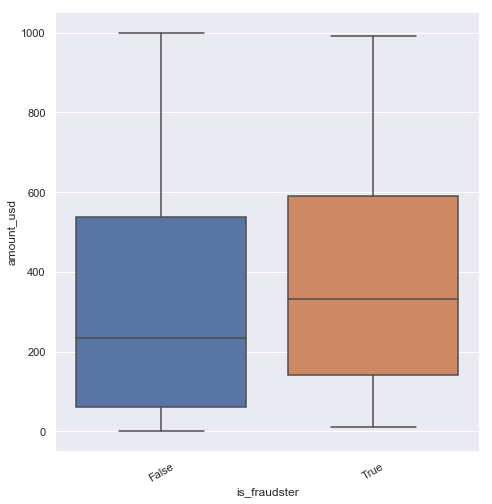

In [24]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='amount_usd',
                           df=max_amount[max_amount.amount_usd < 1000], 
                           height=7)

### 2.2.11. TRANSACTIONS. Research max amount (big)

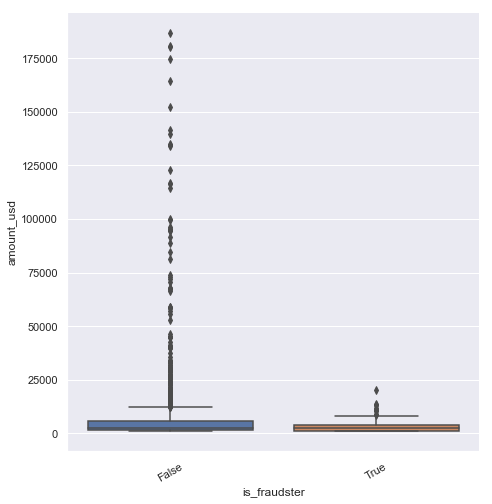

In [25]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='amount_usd',
                           df=max_amount[max_amount.amount_usd > 1000], 
                           height=7)

### 2.2.10.2. TRANSACTIONS. Research mean amount (small)

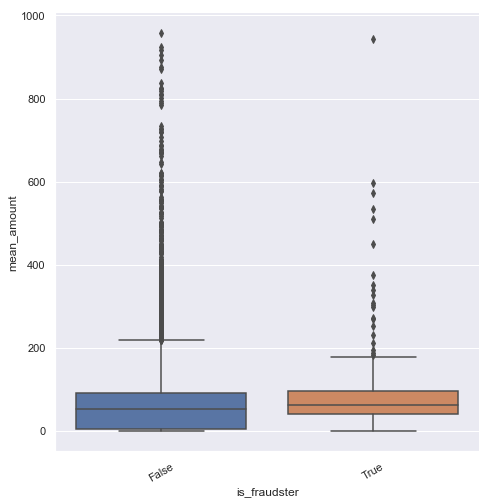

In [26]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='mean_amount',
                           df=users[users.mean_amount < 1000], 
                           height=7)

### 2.2.10.3. TRANSACTIONS. Research mean amount (big)

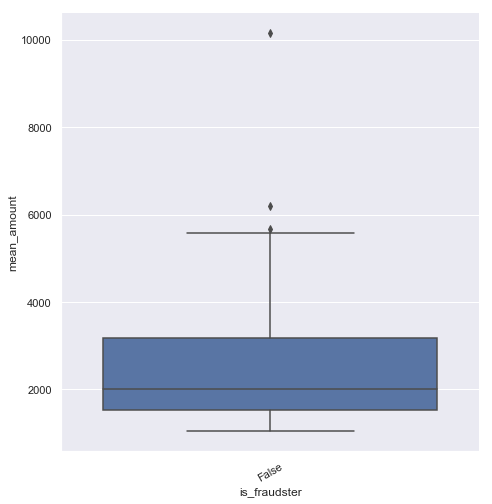

In [27]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='mean_amount',
                           df=users[users.mean_amount >= 1000], 
                           height=7)

**Users fraudsters often make small purchases (on average). At least on the chart with amounts over 1000 USD they are completely absent**

* **Userful featur for small transactions.**

### 2.2.12. TRANSACTIONS. Research Merchant country

is_user_country 
 0 
 1 
 
 
 is_fraudster 
 
 
 
 
 
 
 False 
 56.15 
 43.85 
 
 
 True 
 26.33 
 73.67 
 
 
 All 
 55.28 
 44.72 
 
 
 
 
 
 is_user_country 
 0 
 1 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 False 
 5615 
 4385 
 10000 
 
 
 True 
 79 
 221 
 300 
 
 
 All 
 5694 
 4606 
 10300

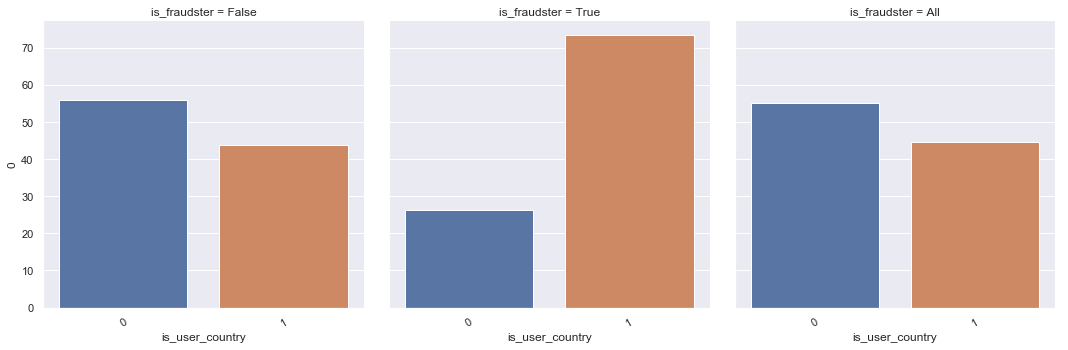

In [28]:
tmp = visualize_categorical(column_y=users.is_fraudster, column_x=users.is_user_country)

**Users fraudsters most often have merchant country == user's country. But this feature contains a lot of NULL values. Maybe It is a bad idea to use it.**

### 2.2.13. TRANSACTIONS. Research diff_date (created-first_trans) - first 15 munutes

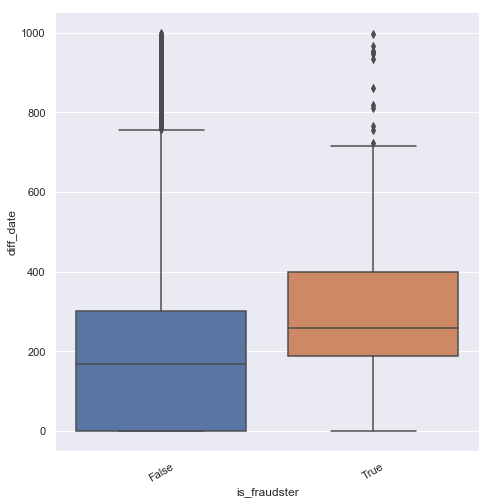

In [29]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='diff_date',
                           df=users[users.diff_date < 1000], 
                           height=7)

* **Non-fraud users more faster**

### 2.2.14. TRANSACTIONS. Research diff_date (created-first_trans) - first 15 munutes

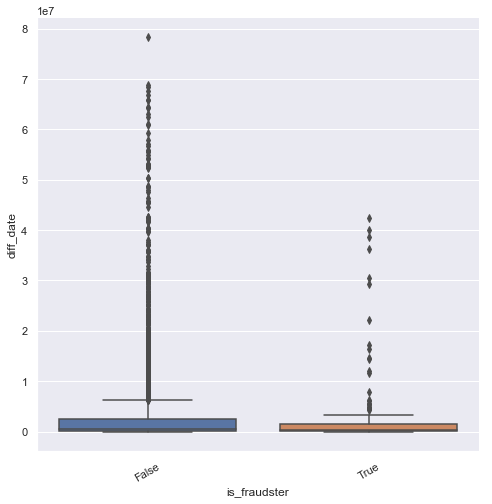

In [30]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='diff_date',
                           df=users[users.diff_date > 1000], 
                           height=7)

### 2.2.15. TRANSACTIONS. Research first amounnt vs country (fraud) - small

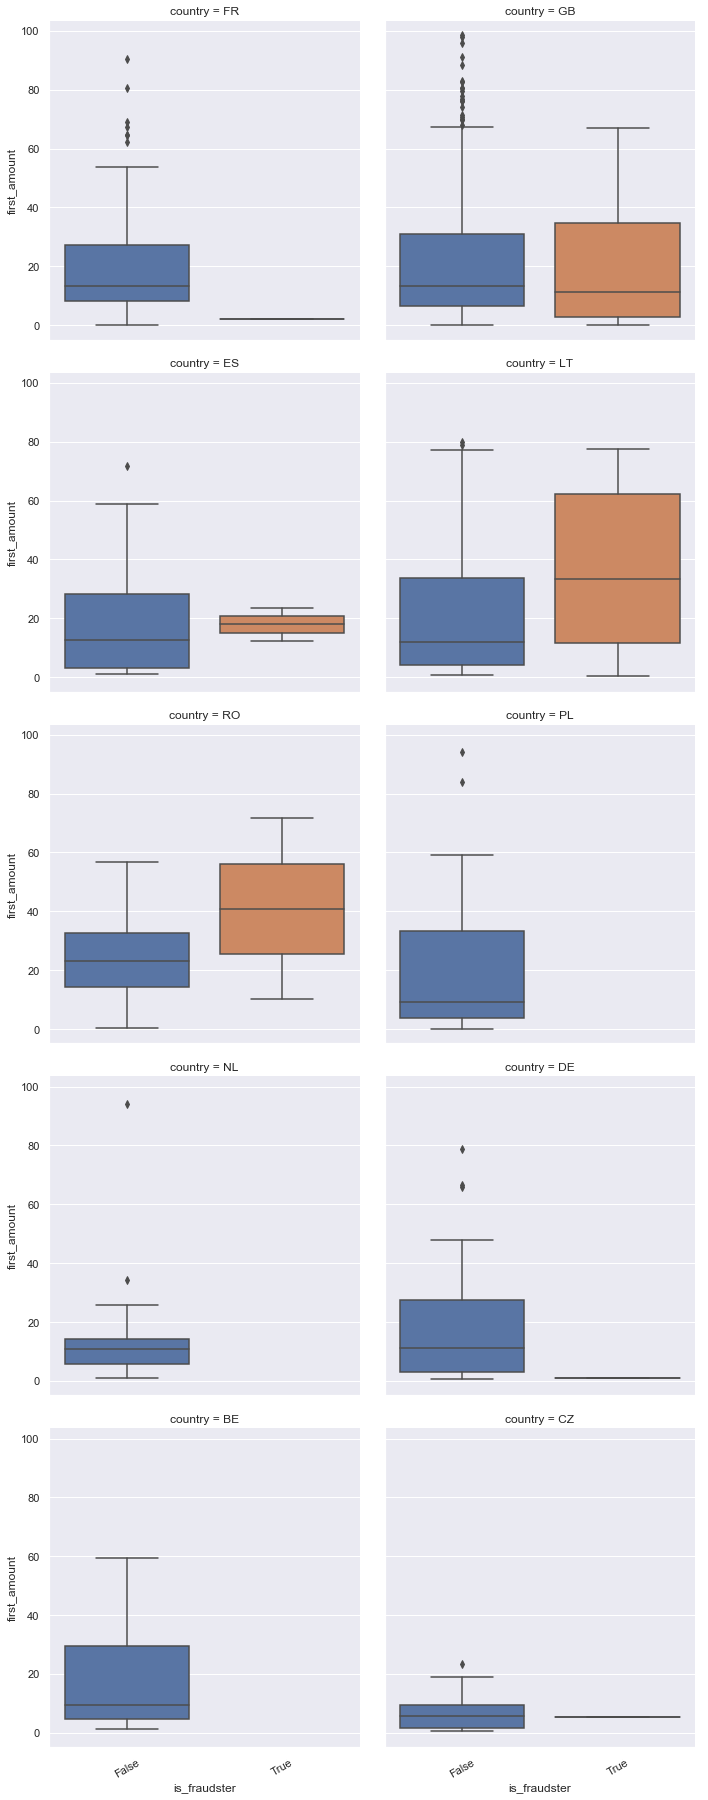

In [31]:
tmp = visualize_continuous(column_x='is_fraudster', 
                           column_y='first_amount',
                           col='country',col_wrap=2,
                           df=sub_user[(sub_user.first_amount> 0) & (sub_user.first_amount < 100)], 
                           height=5)

### 2.2.16. TRANSACTIONS. Has transactions

has_transactions 
 0 
 1 
 
 
 is_fraudster 
 
 
 
 
 
 
 False 
 22.78 
 77.22 
 
 
 True 
 0.33 
 99.67 
 
 
 All 
 22.13 
 77.87 
 
 
 
 
 
 has_transactions 
 0 
 1 
 All 
 
 
 is_fraudster 
 
 
 
 
 
 
 
 False 
 2278 
 7722 
 10000 
 
 
 True 
 1 
 299 
 300 
 
 
 All 
 2279 
 8021 
 10300

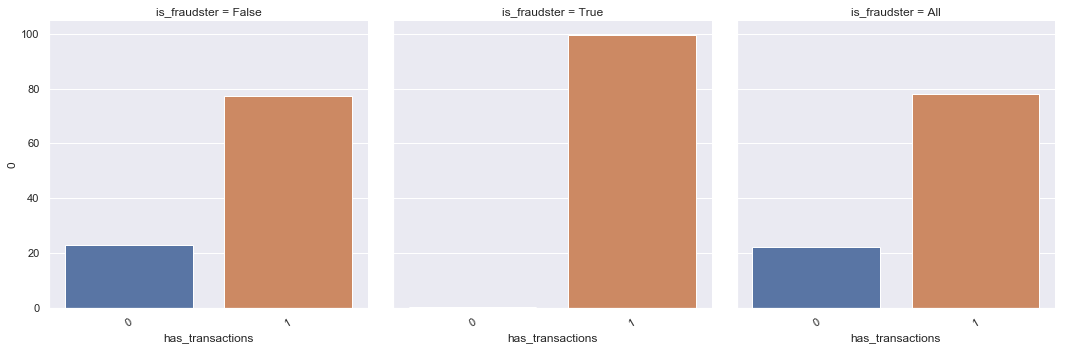

In [32]:
tmp = visualize_categorical(column_y=users.is_fraudster, column_x=users.has_transactions)

**Users without transactions can't be attributed to a fraudster (at least at this stage)**

# 3. Model

Text(0.5, 1.0, 'Heatmap of Correlation')

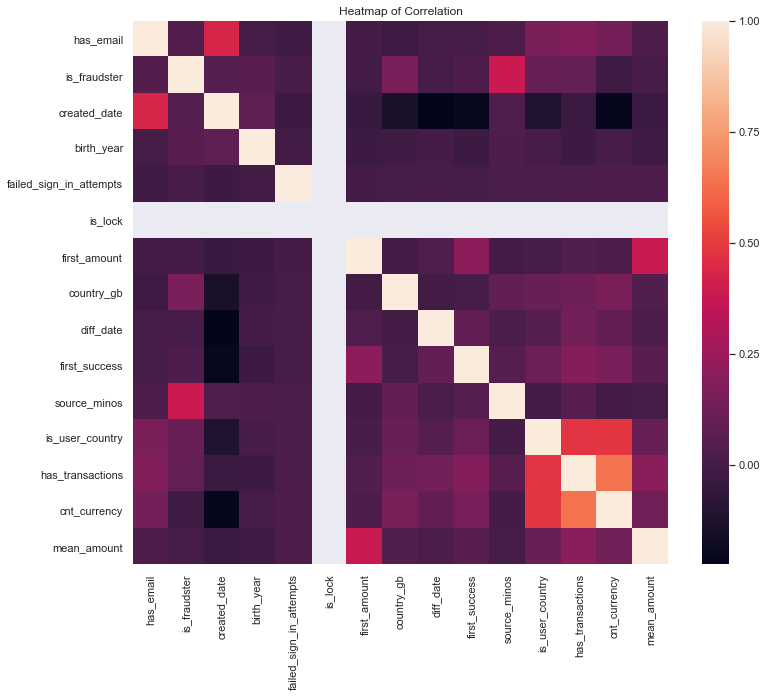

In [33]:
corr = users.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

## 3.1. Choose model

We have unbalanced class. Let's try three ways to fix it:
* Undesampling
* SMOTE
* Combine

And models (for classification):
* Logistic Regression
* KNN
* LDA
* CART
* SVM
* XGB
* RF

And build plot (roc auc score)

[{data_preprocessing.py:144} INFO - PREPROCESSING. Get features ['terms_version', 'type_freq', 'state_freq', 'kyc', 'created_date', 'birth_year', 'has_email', 'source_minos', 'first_success', 'country_gb', 'diff_date', 'has_transactions', 'cnt_currency']
[{data_preprocessing.py:150} INFO - PREPROCESSING. Dummy
[{data_preprocessing.py:203} INFO - PREPROCESSING. Get dummy ['terms_version', 'type_freq', 'state_freq', 'kyc']
[{data_preprocessing.py:209} INFO - PREPROCESSING. Scalar X set
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/scaler.pkl
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/column.pkl
[{data_preprocessing.py:159} INFO - PREPROCESSING. Split test train
[{data_preprocessing.py:166} INFO - PREPROCESSING. Sampling = under
[{data_preprocessing.py:336} INFO - Shape before = (8240, 35), (8240,)
[{data_preprocessing.py:340} INFO - Shape after x = (480, 35), y = (480,) 
[{models.py

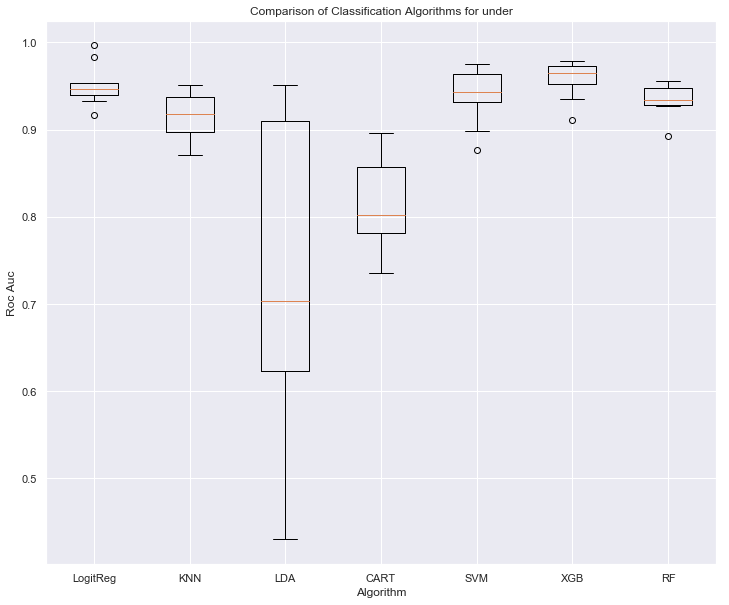

[{data_preprocessing.py:144} INFO - PREPROCESSING. Get features ['terms_version', 'type_freq', 'state_freq', 'kyc', 'created_date', 'birth_year', 'has_email', 'source_minos', 'first_success', 'country_gb', 'diff_date', 'has_transactions', 'cnt_currency']
[{data_preprocessing.py:150} INFO - PREPROCESSING. Dummy
[{data_preprocessing.py:203} INFO - PREPROCESSING. Get dummy ['terms_version', 'type_freq', 'state_freq', 'kyc']
[{data_preprocessing.py:209} INFO - PREPROCESSING. Scalar X set
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/scaler.pkl
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/column.pkl
[{data_preprocessing.py:159} INFO - PREPROCESSING. Split test train
[{data_preprocessing.py:166} INFO - PREPROCESSING. Sampling = smote
[{data_preprocessing.py:336} INFO - Shape before = (8240, 35), (8240,)
[{data_preprocessing.py:340} INFO - Shape after x = (16000, 35), y = (16000,) 
[{model

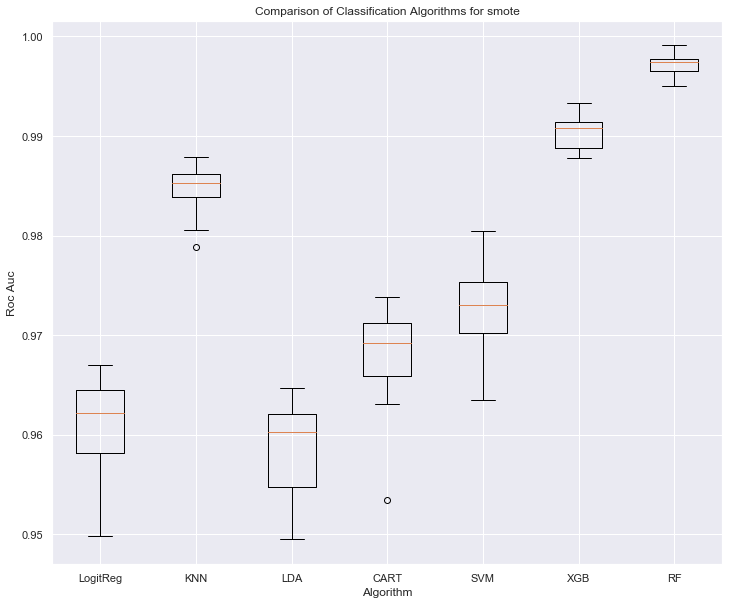

[{data_preprocessing.py:144} INFO - PREPROCESSING. Get features ['terms_version', 'type_freq', 'state_freq', 'kyc', 'created_date', 'birth_year', 'has_email', 'source_minos', 'first_success', 'country_gb', 'diff_date', 'has_transactions', 'cnt_currency']
[{data_preprocessing.py:150} INFO - PREPROCESSING. Dummy
[{data_preprocessing.py:203} INFO - PREPROCESSING. Get dummy ['terms_version', 'type_freq', 'state_freq', 'kyc']
[{data_preprocessing.py:209} INFO - PREPROCESSING. Scalar X set
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/scaler.pkl
[{utils.py:47} INFO - Save obj to /Users/valeriakaravaeva/Documents/git/_LK/FraudDetection/output/column.pkl
[{data_preprocessing.py:159} INFO - PREPROCESSING. Split test train
[{data_preprocessing.py:166} INFO - PREPROCESSING. Sampling = combine
[{data_preprocessing.py:336} INFO - Shape before = (8240, 35), (8240,)
[{data_preprocessing.py:340} INFO - Shape after x = (15038, 35), y = (15038,) 
[{mod

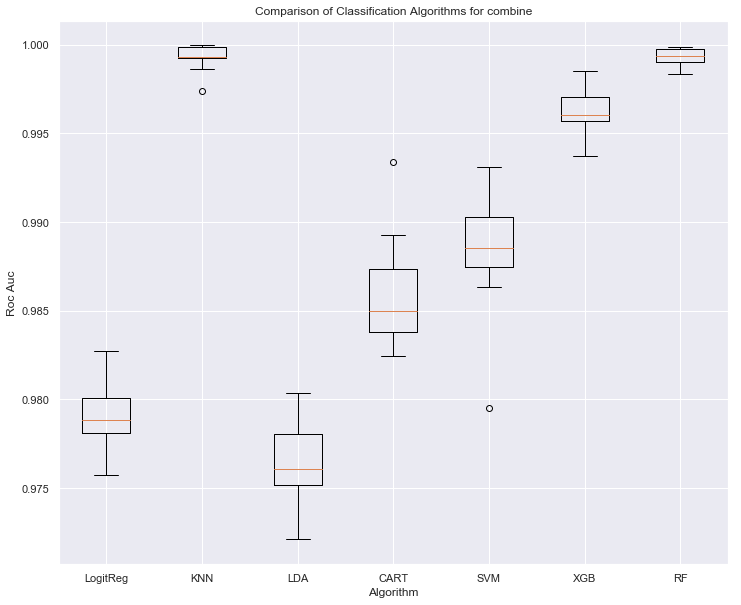

In [34]:

model_obj = FraudDetection()

model_obj.pipeline_choose_sampling(users=users, 
                                   transactions=transactions, types_sampling=['under', 'smote', 'combine'])

## 3.2. Train model

Choose **combine** approach and **RandomForest** with parameters which I chose with gridSearch (you can see in config file)

In [35]:

model_obj = FraudDetection(uuid='44bd7ca5-7a84-41d8-a206-1a307067393c')
model_obj.pipeline_train_predict()

[{data_preprocessing.py:88} INFO - USERS. Convert data
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM users
[{etl_query.py:46} INFO - USERS. Shape = (10300, 11)
[{data_preprocessing.py:70} INFO - USERS. Convert date to numeric (days)
[{data_preprocessing.py:76} INFO - USERS. Rename STATE to state_user
[{data_preprocessing.py:91} INFO - TRANSACTIONS. Convert data
[{etl_query.py:52} INFO - Connect to postgresql://localhost:5432/fraud
[{etl_query.py:60} INFO - Execute query = SELECT * FROM transactions
[{etl_query.py:46} INFO - TRANSACTIONS. Shape = (0, 11)
[{data_preprocessing.py:95} INFO - FEATURE TABLE. Convert has_email to int
[{data_preprocessing.py:98} INFO - FEATURE TABLE. Create first_amount, first_date for users
[{data_preprocessing.py:101} INFO - FEATURE TABLE. Create country_gb (bool-int)
[{data_preprocessing.py:104} INFO - FEATURE TABLE. Create diff date (first_transactions - created date)
[{data_p

## Conclusion

Model needs to be improved. To improve it, we can try the following:
* Yake transactions not just spending
* Tuning parameters
* Try other models
* Generation of new features (more in-depth data exploration)
* Research feature of merchant country and merchant category